In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import Final Dataset

In [2]:
df = pd.read_csv('process_csv_stage_3.csv')
df

,old_index,preprocessed_text,topic_lda,priority
0,1,good morning name appreciate could help put st...,2,3
1,2,upgraded card tell agent upgrade anniversary d...,5,1
2,10,chase card report however fraudulent applicati...,2,3
3,11,try book ticket come across offer apply toward...,5,3
4,14,grand son give check deposit chase account fun...,6,3
...,...,...,...,...
21067,78303,chase card customer well decade offer multiple...,5,3
21068,78309,wednesday call chas visa credit card provider ...,8,1
21069,78310,familiar pay understand great risk provide con...,3,2
21070,78311,flawless credit chase credit card chase freedo...,4,3


# TF-IDF text representation

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = df['preprocessed_text']

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
X.shape

(21072, 16306)

In [4]:
vectorizer.get_feature_names_out()

array(['aad', 'aba', 'abandon', ..., 'zoom', 'zur', 'zyk'], dtype=object)

# Data Partition

In [5]:
# split into training set and validation set
from sklearn.model_selection import train_test_split

y = df[['topic_lda','priority']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16857, 16306)
(4215, 16306)
(16857, 2)
(4215, 2)


# Model Building

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier

dt = MultiOutputClassifier(DecisionTreeClassifier(random_state=42)).fit(X_train, y_train)

In [8]:
dt.score(X_test,y_test)

0.3055753262158956

In [9]:
dt_preds = dt.predict(X_test)

In [10]:
dt_preds

array([[6, 3],
       [1, 3],
       [8, 1],
       ...,
       [2, 3],
       [0, 3],
       [8, 3]], dtype=int64)

In [11]:
dt_preds[:, 0]

array([6, 1, 8, ..., 2, 0, 8], dtype=int64)

In [12]:
dt_preds[:, 1]

array([3, 3, 1, ..., 3, 3, 3], dtype=int64)

# Evaluation

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

================ Ticket Category =================
Accuracy:  0.5283511269276394
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.66      0.66       835
           1       0.47      0.45      0.46       371
           2       0.43      0.45      0.44       368
           3       0.20      0.21      0.21       161
           4       0.39      0.42      0.41       262
           5       0.52      0.49      0.50       380
           6       0.61      0.61      0.61       669
           7       0.54      0.55      0.54       281
           8       0.51      0.51      0.51       888

    accuracy                           0.53      4215
   macro avg       0.48      0.48      0.48      4215
weighted avg       0.53      0.53      0.53      4215



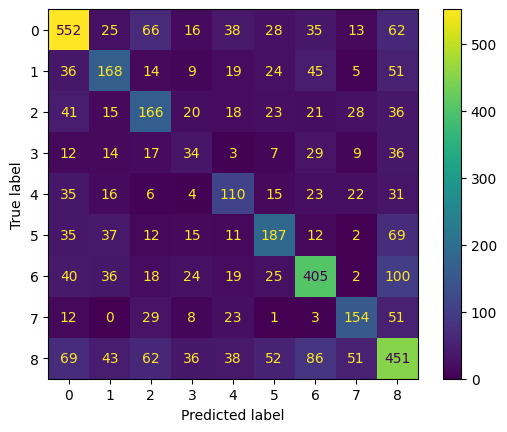

In [14]:
print(f'{" Ticket Category ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['topic_lda'], y_pred=dt_preds[:, 0]))
print("Classification Report:\n",classification_report(y_test['topic_lda'], dt_preds[:, 0]))

cm = confusion_matrix(y_true=y_test['topic_lda'], y_pred=dt_preds[:, 0])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(9)])
cm_display.plot()
plt.show()

================ Ticket Priority =================
Accuracy:  0.5546856465005932
Classification Report:
               precision    recall  f1-score   support

           1       0.41      0.40      0.41       805
           2       0.43      0.43      0.43      1282
           3       0.68      0.69      0.68      2128

    accuracy                           0.55      4215
   macro avg       0.51      0.51      0.51      4215
weighted avg       0.55      0.55      0.55      4215



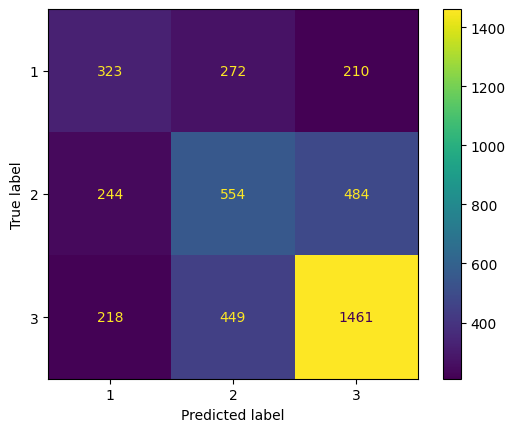

In [15]:
print(f'{" Ticket Priority ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['priority'], y_pred=dt_preds[:, 1]))
print("Classification Report:\n",classification_report(y_test['priority'], dt_preds[:, 1]))

cm = confusion_matrix(y_true=y_test['priority'], y_pred=dt_preds[:, 1])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(1,4)])
cm_display.plot()
plt.show()

# Tuning

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
param_grid = {
    "estimator__min_samples_split": np.linspace(0.01, 0.05, 5),
    "estimator__min_samples_leaf": np.linspace(0.005, 0.025, 5),
    "estimator__max_depth":[10,20,50],
    "estimator__max_leaf_nodes":[5,10,50,100]
}

In [18]:
grid_search = GridSearchCV(
    estimator=MultiOutputClassifier(DecisionTreeClassifier(random_state=42)), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    verbose=2)

In [19]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


GridSearchCV(cv=5,
             estimator=MultiOutputClassifier(estimator=DecisionTreeClassifier(random_state=42)),
             n_jobs=-1,
             param_grid={'estimator__max_depth': [10, 20, 50],
                         'estimator__max_leaf_nodes': [5, 10, 50, 100],
                         'estimator__min_samples_leaf': array([0.005, 0.01 , 0.015, 0.02 , 0.025]),
                         'estimator__min_samples_split': array([0.01, 0.02, 0.03, 0.04, 0.05])},
             verbose=2)

In [20]:
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'estimator__max_depth': 20, 'estimator__max_leaf_nodes': 100, 'estimator__min_samples_leaf': 0.005, 'estimator__min_samples_split': 0.02}


In [21]:
bestdt = grid_search.best_estimator_

In [22]:
best_dt_score = bestdt.score(X_test, y_test)
print("Best model accuracy:", best_dt_score)

Best model accuracy: 0.3169632265717675


# Evaluation After Tuning

In [23]:
bestdt_preds = bestdt.predict(X_test)

================ Ticket Category =================
Accuracy:  0.5383155397390272


C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.72      0.65       835
           1       0.53      0.33      0.41       371
           2       0.46      0.35      0.40       368
           3       0.00      0.00      0.00       161
           4       0.49      0.32      0.39       262
           5       0.44      0.52      0.48       380
           6       0.59      0.72      0.65       669
           7       0.54      0.63      0.58       281
           8       0.51      0.54      0.52       888

    accuracy                           0.54      4215
   macro avg       0.46      0.46      0.45      4215
weighted avg       0.51      0.54      0.52      4215



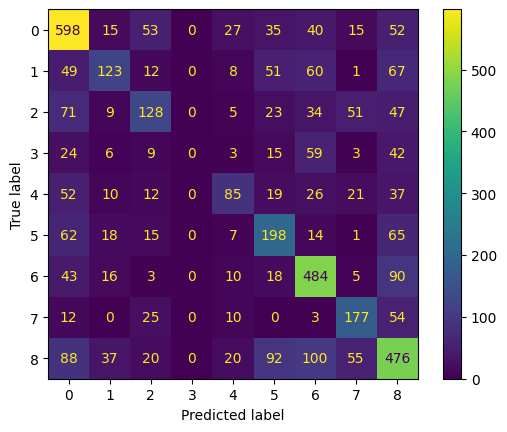

In [24]:
print(f'{" Ticket Category ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['topic_lda'], y_pred=bestdt_preds[:, 0]))
print("Classification Report:\n",classification_report(y_test['topic_lda'], bestdt_preds[:, 0]))

cm = confusion_matrix(y_true=y_test['topic_lda'], y_pred=bestdt_preds[:, 0])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(9)])
cm_display.plot()
plt.show()

================ Ticket Priority =================
Accuracy:  0.5786476868327403
Classification Report:
               precision    recall  f1-score   support

           1       0.46      0.40      0.43       805
           2       0.47      0.43      0.45      1282
           3       0.67      0.74      0.70      2128

    accuracy                           0.58      4215
   macro avg       0.53      0.52      0.53      4215
weighted avg       0.57      0.58      0.57      4215



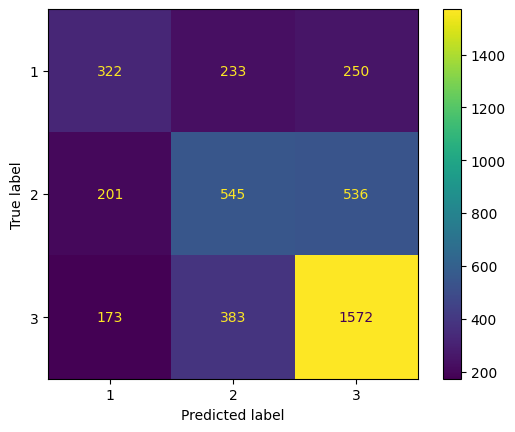

In [25]:
print(f'{" Ticket Priority ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['priority'], y_pred=bestdt_preds[:, 1]))
print("Classification Report:\n",classification_report(y_test['priority'], bestdt_preds[:, 1]))

cm = confusion_matrix(y_true=y_test['priority'], y_pred=bestdt_preds[:, 1])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(1,4)])
cm_display.plot()
plt.show()

# Save tuned model to disk

In [26]:
import os
from pickle import dump
with open(os.path.join(os.getcwd(),'ml_models',"dt_20240720_1.pkl"), "wb") as f:
    dump(bestdt, f, protocol=5)